In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression

from sklearn.metrics import r2_score, make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import joblib

In [12]:
def drop_columns(df):
    """
    Drops the specified columns from the DataFrame and returns the resulting DataFrame.
    Also prints the first few rows of the resulting DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: The DataFrame after dropping the specified columns.
    """
    columns_to_drop = ['espessura', 'Index','Cluster','cluster']
    df = df.drop(columns=columns_to_drop, inplace=True)
    return df

In [13]:
# Step 1: Load the data
file_path = 'df2.xlsx'
data = pd.read_excel(file_path)

In [14]:
drop_columns(data)
data.describe()

,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeça,altura
count,474.000000,474.000000,474.000000,474.000000,474.000000
mean,116.086814,16.965633,14.415042,4.647046,5.163734
std,69.548227,3.226950,2.806282,1.981746,1.118360
min,30.270000,11.500000,1.700000,2.900000,3.200000
25%,51.667500,14.200000,12.000000,3.800000,4.200000
50%,96.670000,16.700000,14.350000,4.500000,5.000000
75%,159.362500,19.600000,16.700000,5.400000,5.800000
max,286.840000,22.600000,19.800000,42.000000,7.800000


In [15]:
# Define features (X) and target (y)
X = data.drop(columns=['peso'])
y = data['peso']

# Handle missing values if needed (impute or remove)
X = X.fillna(X.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a parameter grid for LightGBM
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 10, 20],  # -1 indicates no limit
    'min_child_samples': [20, 50, 100]  # Minimum data per leaf
}

# Define scoring metric
scoring = make_scorer(r2_score)

# Initialize the LightGBM regressor
lgbm_regressor = lgb.LGBMRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_regressor,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available CPU cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-Validation R2 Score:", best_score)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("Test Mean Squared Error:", test_mse)
print("Test R2 Score:", test_r2)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 379, number of used features: 4
[LightGBM] [Info] Start training from score 116.196517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

NameError: name 'mean_squared_error' is not defined

In [33]:
# Step 8: Plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

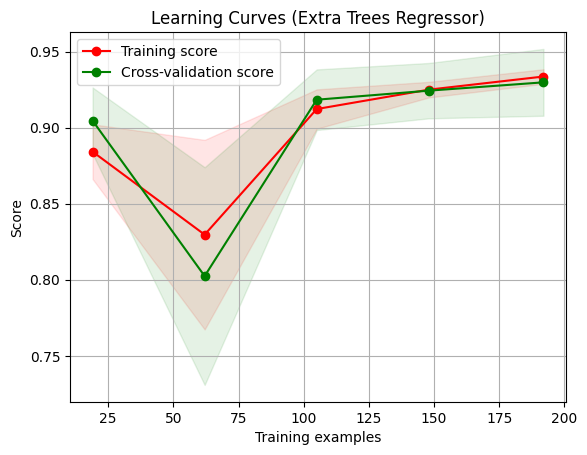

In [34]:
plot_learning_curve(best_model, "Learning Curves (Extra Trees Regressor)", X_train, y_train, cv=5, n_jobs=-1)
plt.show()

In [ ]:
# Save the best model using joblib
model_filename = 'best_lgbm_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

In [36]:
# Step 10: Load the model
loaded_model = joblib.load(model_filename)
print("\nModel loaded:{model_filename}")


Model loaded:{model_filename}


In [37]:
## Vizualiasing some some predictions
print("\nSample Predictions:")
for i in range(10):
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}")


Sample Predictions:
Actual: 544.8, Predicted: 584.9735240090415
Actual: 547.3, Predicted: 575.0028327666637
Actual: 737.06, Predicted: 720.059038578856
Actual: 619.1, Predicted: 686.7498189984783
Actual: 786.66, Predicted: 760.6383444655755
Actual: 949.42, Predicted: 965.4053545779625
Actual: 644.38, Predicted: 630.2414845627857
Actual: 898.4, Predicted: 889.9586938833199
Actual: 976.34, Predicted: 806.6271099621767
Actual: 862.08, Predicted: 860.4089894479423
